In [1]:
import sys

sys.path.append("../src")

In [2]:
from medgc_tesis.pipelines.modeling.backbone import LeNetBackbone, ResNet18Backbone
from medgc_tesis.pipelines.modeling.models.data import DomainAdaptationDataModule
from torch import nn
from tqdm import tqdm
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox

d:\Programs\Anaconda3\envs\medgc-tesis-v2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 48721


In [3]:
import os

os.chdir("..")

In [4]:
%load_ext kedro.extras.extensions.ipython

2022-12-11 12:11:04,375 - root - INFO - Updated path to Kedro project: C:\Users\Lianz\Documents\medgc-tesis
2022-12-11 12:11:06,030 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-12-11 12:11:08,917 - root - INFO - ** Kedro project MEDGC Tesis
2022-12-11 12:11:08,919 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-12-11 12:11:11,656 - root - INFO - Registered line magic `run_viz`


In [5]:
def embedding_plot(X_s, X_t, s_X):
    x_min, x_max = np.min(X_s, axis=0), np.max(X_s, axis=0)
    X_s = (X_s - x_min) / (x_max - x_min)
    X_t = (X_t - x_min) / (x_max - x_min)

    idx = np.arange(X_s.shape[0]) 
    np.random.shuffle(idx)
    idx = idx[:800]

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(X_s[idx, 0], X_s[idx, 1], alpha=0.1, label="MNIST")
    ax.scatter(X_t[idx, 0], X_t[idx, 1], alpha=0.1, label="TDS")

    shown_images = np.array([[1.0, 1.0]])
    offset = 0.05
    for i in range(X_s.shape[0]):
        if np.min(np.sum((X_s[i] - shown_images) ** 2, axis=1)) < 5e-2:
            continue
        shown_images = np.r_[shown_images, [X_s[i]]]
        ax.add_artist(offsetbox.AnnotationBbox(offsetbox.OffsetImage(s_X[i][0, :, :], cmap=plt.cm.gray_r, zoom=0.4), (X_s[i][0] + offset, X_s[i][1] + offset)))
    plt.axis('off')
    plt.xlim(X_s.min(), X_s.max() + offset)
    plt.xlim(X_s.min(), X_s.max() + offset)

In [6]:
das = ["afn", "source_only", "dann", "adda", "bsp", "mdd"]
modelos = ["resnet", "lenet"]
nombres = {
    'afn': "AFN",
    'source_only': "Solo Origen",
    'dann': "DANN",
    'adda': "ADDA",
    'bsp': "DANN+BSP",
    'mdd': "MDD",
    'resnet': "ResNet18",
    'lenet': "LeNet",
}

2022-12-11 12:11:11,853 - kedro.io.data_catalog - INFO - Loading data from `modelo_resnet_afn` (PytorchModelDataSet)...
Calculando features


11it [00:34,  3.09s/it]                      


Aplicando UMAP
Graficando


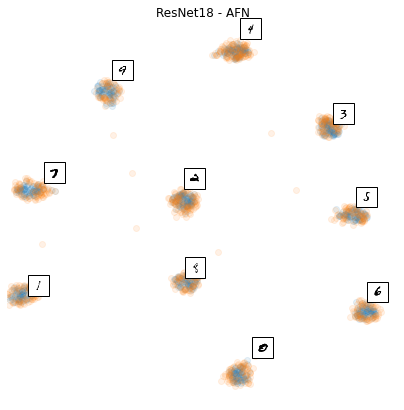

2022-12-11 12:13:10,584 - kedro.io.data_catalog - INFO - Loading data from `modelo_lenet_afn` (PytorchModelDataSet)...


Global seed set to 48721


Calculando features


11it [00:11,  1.07s/it]                      


Aplicando UMAP
Graficando


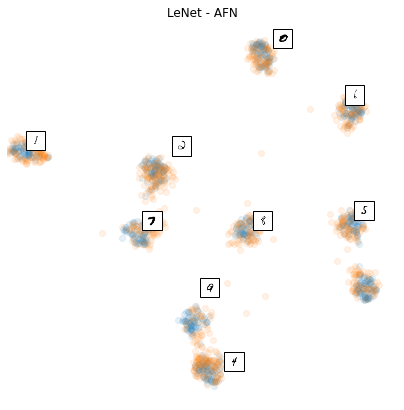

2022-12-11 12:13:51,817 - kedro.io.data_catalog - INFO - Loading data from `modelo_resnet_source_only` (PytorchModelDataSet)...
Calculando features


11it [00:13,  1.27s/it]                      


Aplicando UMAP
Graficando


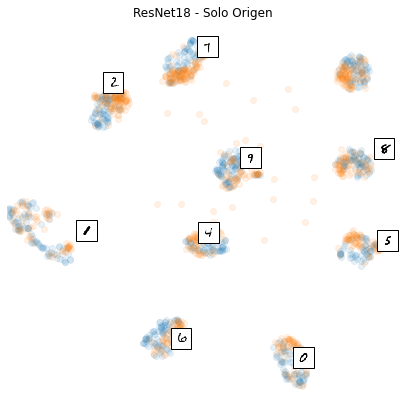

2022-12-11 12:14:35,548 - kedro.io.data_catalog - INFO - Loading data from `modelo_lenet_source_only` (PytorchModelDataSet)...
Calculando features


11it [00:12,  1.10s/it]                      


Aplicando UMAP
Graficando


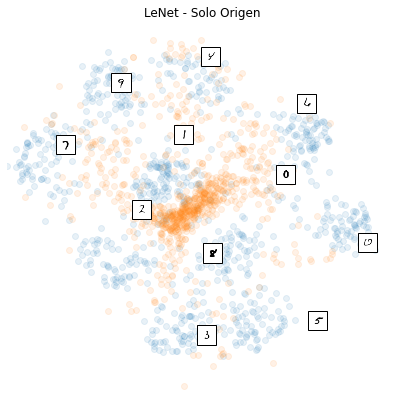

2022-12-11 12:15:20,080 - kedro.io.data_catalog - INFO - Loading data from `modelo_resnet_dann` (PytorchModelDataSet)...
Calculando features


11it [00:14,  1.28s/it]                      


Aplicando UMAP
Graficando


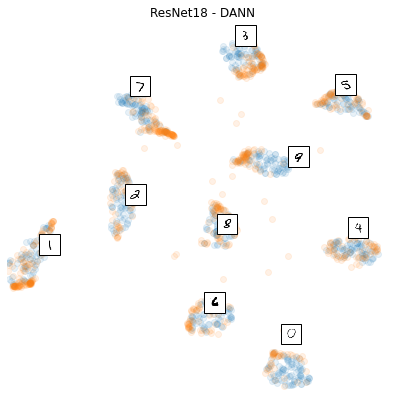

2022-12-11 12:16:02,556 - kedro.io.data_catalog - INFO - Loading data from `modelo_lenet_dann` (PytorchModelDataSet)...
Calculando features


11it [00:12,  1.14s/it]                      


Aplicando UMAP
Graficando


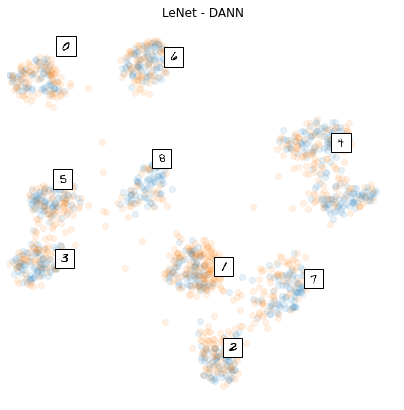

2022-12-11 12:16:44,875 - kedro.io.data_catalog - INFO - Loading data from `modelo_resnet_adda` (PytorchModelDataSet)...
Calculando features


11it [00:14,  1.33s/it]                      


Aplicando UMAP
Graficando


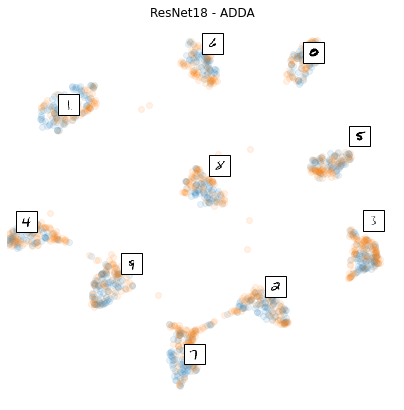

2022-12-11 12:17:28,267 - kedro.io.data_catalog - INFO - Loading data from `modelo_lenet_adda` (PytorchModelDataSet)...
Calculando features


11it [00:12,  1.14s/it]                      


Aplicando UMAP
Graficando


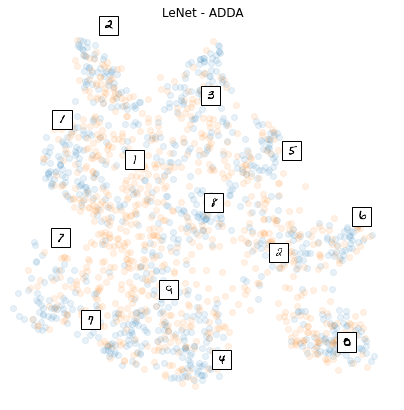

2022-12-11 12:18:10,814 - kedro.io.data_catalog - INFO - Loading data from `modelo_resnet_bsp` (PytorchModelDataSet)...
Calculando features


11it [00:14,  1.33s/it]                      


Aplicando UMAP
Graficando


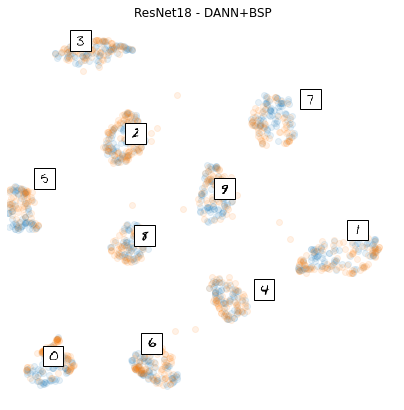

2022-12-11 12:18:54,167 - kedro.io.data_catalog - INFO - Loading data from `modelo_lenet_bsp` (PytorchModelDataSet)...
Calculando features


11it [00:12,  1.14s/it]                      


Aplicando UMAP
Graficando


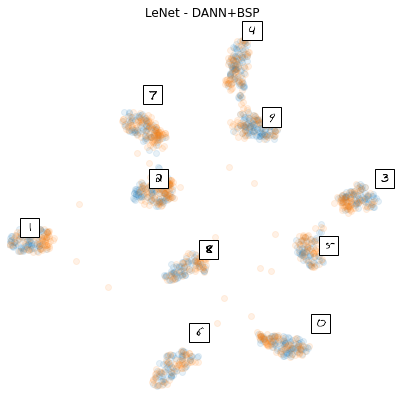

2022-12-11 12:19:35,901 - kedro.io.data_catalog - INFO - Loading data from `modelo_resnet_mdd` (PytorchModelDataSet)...
Calculando features


11it [00:14,  1.31s/it]                      


Aplicando UMAP
Graficando


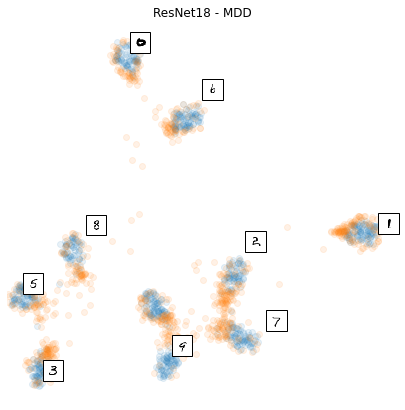

2022-12-11 12:20:20,703 - kedro.io.data_catalog - INFO - Loading data from `modelo_lenet_mdd` (PytorchModelDataSet)...
Calculando features


11it [00:12,  1.11s/it]                      


Aplicando UMAP
Graficando


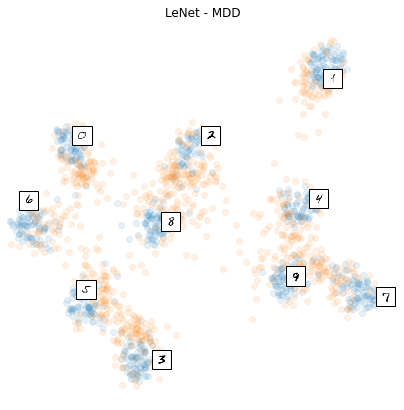

In [7]:
for da in das:
    for modelo in modelos:
        model = catalog.load(f"modelo_{modelo}_{da}")
        backbone = ResNet18Backbone() if modelo == 'resnet' else LeNetBackbone()

        if hasattr(model, "pool_layer"):
            feature_extractor = nn.Sequential(model.backbone, model.pool_layer, model.bottleneck)
        else:
            feature_extractor = nn.Sequential(model.backbone, model.bottleneck)

        feature_extractor = feature_extractor.to("cuda")

        dm = DomainAdaptationDataModule(transform=backbone.data_transform())
        dm.setup(None)
        dataloader = dm.test_dataloader()
        del dm

        x_ss = []
        f_ss = []
        f_tt = []

        print("Calculando features")
        for idx, batch in enumerate(tqdm(dataloader)):
            if idx > 10:
                break

            x_s, _ = batch["mnist"]
            x_t, _ = batch["tds"]
            
            x_s = x_s.to("cuda")
            x_t = x_t.to("cuda")

            f_s = feature_extractor(x_s)
            f_t = feature_extractor(x_t)

            x_ss.append(x_s.cpu().detach())
            f_ss.append(f_s.cpu().detach())
            f_tt.append(f_t.cpu().detach())
        
        s_x = torch.cat(x_ss, dim=0).cpu().detach().numpy()
        s_features = torch.cat(f_ss, dim=0).cpu().detach().numpy()
        t_features = torch.cat(f_tt, dim=0).cpu().detach().numpy()

        print("Aplicando UMAP")
        mapper = umap.UMAP(random_state=33)
        source_feature = mapper.fit_transform(s_features)
        target_feature = mapper.transform(t_features)

        print("Graficando")
        embedding_plot(source_feature, target_feature, s_x)
        plt.title(f"{nombres[modelo]} - {nombres[da]}")
        plt.show()